In [1]:
from data.data import LMDBDataset
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = LMDBDataset(
    lmdb_path=Path('/mnt/ensg/tout_le_monde/Basile/dataset_filtered/data.lmdb')
)

DATASET: Found 205824 samples in /mnt/ensg/tout_le_monde/Basile/dataset_filtered/data.lmdb.


sample['num_electrode'].item()=44
sample['subsection_length'].item()=99
sample['array_type']=tensor([0, 1], dtype=torch.int32)
sample['pseudosection'].shape=torch.Size([21, 41])
sample['norm_log_resistivity_model'].shape=torch.Size([105, 141])


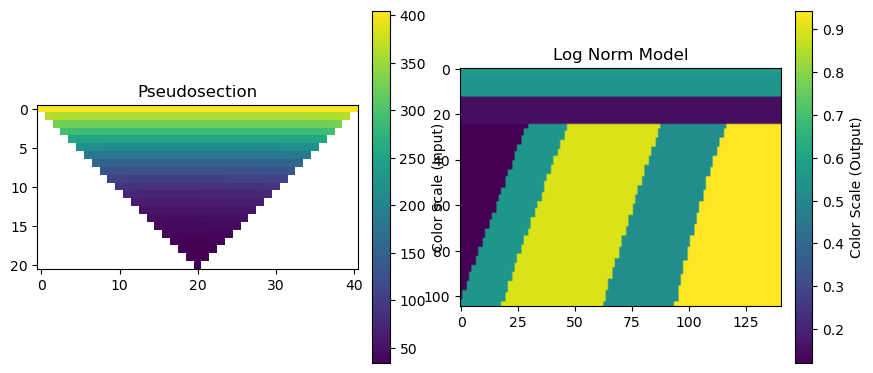

In [55]:
idx = 523
sample = dataset[idx]
print(f"{sample['num_electrode'].item()=}")
print(f"{sample['subsection_length'].item()=}")
print(f"{sample['array_type']=}")
print(f"{sample['pseudosection'].shape=}")
print(f"{sample['norm_log_resistivity_model'].shape=}")

pseudosection = sample['pseudosection']
non_zero_apparent_resistivities = pseudosection[pseudosection != 0]
vmin = non_zero_apparent_resistivities.min().item()

norm_log_resistivity_model = sample['norm_log_resistivity_model']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.get_cmap('viridis')  # You can change this to any colormap you prefer.
cmap.set_under('white')
im1 = ax[0].imshow(pseudosection, vmin=vmin, cmap=cmap)
ax[0].set_title("Pseudosection")
cbar1 = fig.colorbar(im1, ax=ax[0], orientation='vertical', fraction=0.05, pad=0.04)
cbar1.set_label("Color Scale (Input)")
im2 = ax[1].imshow(norm_log_resistivity_model)
ax[1].set_title("Log Norm Model")
cbar2 = fig.colorbar(im2, ax=ax[1], orientation='vertical', fraction=0.05, pad=0.04)
cbar2.set_label("Color Scale (Output)")
plt.show()

In [27]:
import torch
import torch.nn.functional as F
def regrid(x: torch.Tensor) -> torch.Tensor:
    # Get dimensions
    N, C, H, W = x.shape

    # Identify the first and last nonzero columns for each row
    row_mask = x[0, 0] != 0  # Shape: (H, W)
    col_indices = torch.arange(W, device=x.device).expand(H, W)

    col_min = torch.where(row_mask, col_indices, W).amin(dim=1)  # First nonzero column per row
    col_max = torch.where(row_mask, col_indices, -1).amax(dim=1)  # Last nonzero column per row

    # Handle empty rows (avoid invalid ranges)
    col_min[col_min == W] = 0
    col_max[col_max == -1] = W - 1

    # Compute normalized grid coordinates
    j = torch.linspace(0, 1, W, device=x.device).view(1, W)  # Column scale factor
    mapped_cols = col_min.view(H, 1) + (col_max - col_min).view(H, 1) * j  # Shape: (H, W)

    norm_x = (mapped_cols / (W - 1)) * 2 - 1  # Normalize to [-1, 1]
    norm_y = torch.linspace(-1, 1, H, device=x.device).view(H, 1).expand(H, W)  # Shape: (H, W)

    # Stack to create the grid: [N, H, W, 2]
    grid = torch.stack((norm_x, norm_y), dim=-1).unsqueeze(0).expand(N, -1, -1, -1)

    # Perform grid sampling
    print(f"Grid shape: {grid.shape}")
    return F.grid_sample(x, grid, mode='bilinear', align_corners=True)
x = torch.tensor([[pseudosection_wo_nan]], dtype=torch.float)
print(f"Input shape: {x.shape}")
out = regrid(x)
print(f"Output shape: {out.shape}")

Input shape: torch.Size([1, 1, 24, 64])
Grid shape: torch.Size([1, 24, 64, 2])
Output shape: torch.Size([1, 1, 24, 64])


In [15]:
import torch
import torch.nn.functional as F

# Define a trapezoidal input
x = torch.tensor([[pseudosection_wo_nan]], dtype=torch.float)

# Get dimensions
N, C, H, W = x.shape

# Create an empty grid for sampling, shape: [N, H, W, 2]
grid = torch.zeros((N, H, W, 2), dtype=torch.float)

# Compute the valid region for each row
valid_ranges = []
for i in range(H):
    row = x[0, 0, i].numpy()  # Get the row values as a NumPy array
    nonzero_indices = (row != 0).nonzero()[0]  # Indices where values are nonzero
    if len(nonzero_indices) > 0:
        col_min, col_max = nonzero_indices[0], nonzero_indices[-1]  # First & last nonzero index
    else:
        col_min, col_max = 0, W - 1  # Default case (not expected in valid input)
    valid_ranges.append((col_min, col_max))

# Fill the grid
for i in range(H):
    col_min, col_max = valid_ranges[i]
    for j in range(W):
        # Compute the mapped source column based on valid region
        col = col_min + (col_max - col_min) * (j / (W - 1))

        # Normalize coordinates to [-1, 1] for grid_sample
        norm_x = (col / (W - 1)) * 2 - 1
        norm_y = (i / (H - 1)) * 2 - 1

        grid[0, i, j, 0] = norm_x  # x coordinate (columns)
        grid[0, i, j, 1] = norm_y  # y coordinate (rows)

# Now use grid_sample to remap x using the custom grid  
out = F.grid_sample(x, grid, mode='bilinear', align_corners=True)
print("Output shape:", out.shape)


Output shape: torch.Size([1, 1, 7, 21])


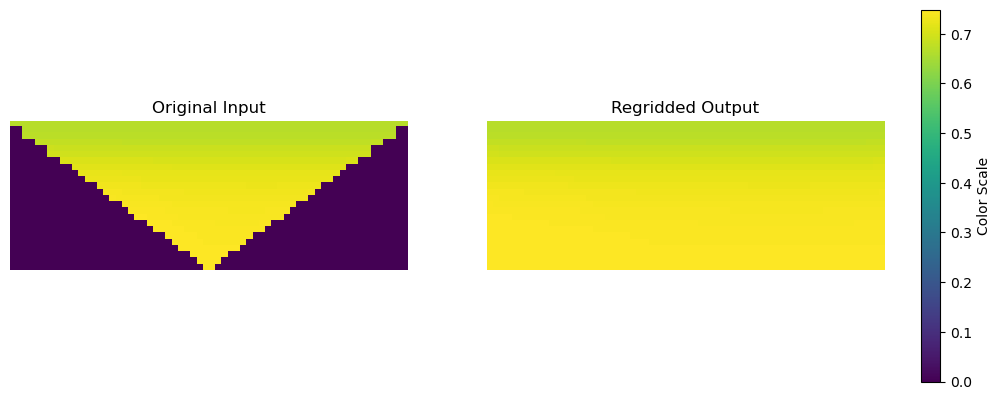

In [28]:
vmin = min(np.nanmin(pseudosection), out.min())
vmax = max(np.nanmax(pseudosection), out.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(pseudosection, norm=norm)
ax[0].set_title("Original Input")
ax[0].axis('off')
im2 = ax[1].imshow(out[0, 0], norm=norm)
ax[1].set_title("Regridded Output")
ax[1].axis('off')

# Add a single colorbar
cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Color Scale")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.transpose_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2)
        # self.transpose_conv1 = nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2)

        self.transpose_conv2 = nn.ConvTranspose2d(16, 16, kernel_size=(5, 3), stride=(4, 2))
        self.conv3 = nn.Conv2d(16, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x, output):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        print(f"After conv1 shape: {x.shape}")
        x = F.relu(self.conv2(x))
        print(f"After conv2 shape: {x.shape}")
        x = F.relu(self.transpose_conv1(x))
        print(f"After transpose_conv1 shape: {x.shape}")
        x = F.relu(self.transpose_conv2(x))
        print(f"After transpose_conv2 shape: {x.shape}")
        x = F.interpolate(x, size=(output.shape[2], output.shape[3]), mode="bilinear", align_corners=False)
        print(f"After interpolate shape: {x.shape}")
        x = self.conv3(x)
        print(f"After conv3 shape: {x.shape}")
        return x

cnn_model = CNN(input_channels=1, output_channels=1)

In [8]:
# input_tensor = torch.tensor([[pseudosection_wo_nan]], dtype=torch.float)
input_tensor = out
target_tensor = torch.tensor([[log_norm_model]], dtype=torch.float)
output_tensor = cnn_model(input_tensor, target_tensor)
plt.imshow(output_tensor[0, 0].detach().numpy())
plt.title("CNN Output")
plt.colorbar()
plt.show()

NameError: name 'out' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [9]:

class DynamicConv2D(nn.Module):
    def __init__(self,
                 stride: int = 1,
                 padding: str = "same"
                 ) -> None:
        """
        A convolutional layer that takes dynamically generated kernels.
        """
        super().__init__()
        self.stride: int = stride
        self.padding: str = padding

    def forward(self,
                x: torch.Tensor,
                kernels: torch.Tensor,
                batch_size: int,
                ) -> torch.Tensor:
        # Use group convolution so that each image in the batch uses its own
        # kernel.
        x = F.conv2d(x,
                     kernels,
                     stride=self.stride,
                     padding=self.padding,
                     groups=batch_size)

        return x


class DynamicConvNet(nn.Module):
    def __init__(self,
                 in_channels: list[int],
                 ) -> None:
        """
        A network composed of several dynamic convolution layers.
        """
        super().__init__()

        self.num_layers = len(in_channels)
        self.dynamic_conv_layers = nn.ModuleList(
            [DynamicConv2D() for _ in range(self.num_layers)]
        )

    def forward(self,
                x: torch.Tensor,
                kernels: list[torch.Tensor],
                batch_size: int,
                ) -> torch.Tensor:
        for conv_layer, kernel in zip(self.dynamic_conv_layers, kernels):
            x = conv_layer(x, kernel, batch_size)
        return x

class CNN(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.transpose_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2)
        self.transpose_conv2 = nn.ConvTranspose2d(16, 16, kernel_size=(5, 3), stride=(4, 2))
        self.conv3 = nn.Conv2d(16, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x, output):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.transpose_conv1(x))
        x = F.relu(self.transpose_conv2(x))
        x = F.interpolate(x, size=(output.shape[2], output.shape[3]), mode="bilinear", align_corners=False)
        x = self.conv3(x)
        return x

NameError: name 'nn' is not defined

In [12]:
del dataset

NameError: name 'dataset' is not defined